In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.9.1
sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.1
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.9.1
keras.api._v2.keras 2.9.0


In [3]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [4]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)

(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [8]:
# RandomizedSearchCV
# 1. 因为是sklearn的接口，转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    # 因为不知道第一个输入的shape是多大的，因此需要单独从for循环里拿出来，for循环里的是输出再次作为输入
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

# KerasRegressor返回一个sk的model,build_fn是一个回调函数
sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model)  # 要求这里必须是一个函数
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
# 下面只是先对sk封装tf模型的一个测试
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/10


/tmp/ipykernel_2852/1839189212.py:21: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(build_fn = build_model)


363/363 [==============================] - 1s 2ms/step - loss: 1.3934 - val_loss: 0.7765
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7056 - val_loss: 0.6981
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.6767 - val_loss: 0.6347
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5820 - val_loss: 0.5862
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5423 - val_loss: 0.5573
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5064 - val_loss: 0.5508
Epoch 7/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4909 - val_loss: 0.5074
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4757 - val_loss: 0.4935
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4717 - val_loss: 0.4843
Epoch 10/10
363/363 [==============================] - 1s 1ms/step - loss: 0.4595 - val_loss: 0.4777


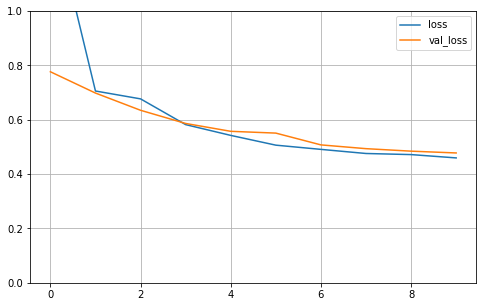

In [9]:
# 未使用网格搜索时
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [10]:
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],  # 名字必须和上面的一样
    "layer_size": [5, 10, 20, 30],
    "learning_rate": [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

#随机搜索
# random_search_cv = RandomizedSearchCV(sklearn_model,
#                                       param_distribution)
# random_search_cv.fit(x_train_scaled, y_train, epochs = 5,
#                      validation_data = (x_valid_scaled, y_valid),
#                      callbacks = callbacks)

# 网格搜索
grid_search_cv = GridSearchCV(sklearn_model, param_distribution)

grid_search_cv.fit(x_train_scaled, y_train, epochs = 5,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 10.6875 - val_loss: 9.3837
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 7.6067 - val_loss: 6.9297
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 5.7991 - val_loss: 5.3868
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 4.6038 - val_loss: 4.3218
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.9426
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 7.2284 - val_loss: 6.4413
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.5754 - val_loss: 5.1261
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 4.5637 - val_loss: 4.2539
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.8581 - val_loss: 3.6221
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.7267
Epoch 1/5
291/291 [==============================] 

291/291 [==============================] - 0s 2ms/step - loss: 0.8147 - val_loss: 0.8464
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.7856
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.5529 - val_loss: 0.8534
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.7660 - val_loss: 0.7556
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6824 - val_loss: 0.6873
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6637 - val_loss: 0.6688
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.5801
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 1.5398 - val_loss: 0.7519
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6790 - val_loss: 0.6762
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6120 - val_loss: 0.6278
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 4.2950 - val_loss: 3.9026
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.6953 - val_loss: 3.3873
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.2216 - val_loss: 2.9812
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 2.8436 - val_loss: 2.6650
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.3502
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 6.3060 - val_loss: 5.9075
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.2828 - val_loss: 4.9633
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.4971 - val_loss: 4.2312
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.8835 - val_loss: 3.6578
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.6551
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 0s 2ms/step - loss: 0.5186 - val_loss: 0.5466
Epoch 5/5
73/73 [==============================] - 0s 976us/step - loss: 0.5242
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2405 - val_loss: 0.6270
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5403 - val_loss: 0.5503
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4866 - val_loss: 0.5063
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4577 - val_loss: 0.4791
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4521
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9171 - val_loss: 0.5580
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5193 - val_loss: 0.5037
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4872 - val_loss: 0.4778
Epoch 4/5
291/291 [==============================] - 1s 2ms/

291/291 [==============================] - 1s 2ms/step - loss: 5.5521 - val_loss: 5.4249
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.9398 - val_loss: 4.8469
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.4272 - val_loss: 4.3609
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.9953 - val_loss: 3.9499
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.3189
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.7950 - val_loss: 4.7255
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.2167 - val_loss: 4.1760
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.7287 - val_loss: 3.7098
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.3143 - val_loss: 3.3122
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.8672
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.4117 - val_loss: 0.4400
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4096
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0428 - val_loss: 0.8938
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2013 - val_loss: 0.5049
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4367 - val_loss: 0.4358
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4064 - val_loss: 0.4056
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.3918
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9778 - val_loss: 0.5751
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5062 - val_loss: 0.5191
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4617 - val_loss: 0.4745
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 2.6481 - val_loss: 1.2705
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9541 - val_loss: 0.8511
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.7424 - val_loss: 0.7695
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6940 - val_loss: 0.7299
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6407
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.9571 - val_loss: 1.3359
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.8794 - val_loss: 0.8754
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6850 - val_loss: 0.7488
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6240 - val_loss: 0.6879
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6090
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 0s 2ms/step - loss: 3.7341 - val_loss: 3.6801
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.1763
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 6.0715 - val_loss: 5.5562
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 4.8521 - val_loss: 4.5568
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 4.0205 - val_loss: 3.8449
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 3.4179 - val_loss: 3.3115
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 2.7423
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.3513 - val_loss: 4.0756
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 3.6361 - val_loss: 3.4123
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.0572 - val_loss: 2.8784
Epoch 4/5
291/291 [==============================] - 0s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.8841 - val_loss: 0.6632
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5706 - val_loss: 0.5830
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5290 - val_loss: 0.5568
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5090 - val_loss: 0.5415
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4949
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.5620 - val_loss: 0.7691
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6644 - val_loss: 0.6619
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5907 - val_loss: 0.6070
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5391 - val_loss: 0.5469
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4754
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 0s 2ms/step - loss: 3.5941 - val_loss: 3.4344
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.3095
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.5352 - val_loss: 4.2404
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.9576 - val_loss: 3.6709
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4640 - val_loss: 3.1899
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 3.0510 - val_loss: 2.7846
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.3394
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.2883 - val_loss: 5.3190
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 4.8025 - val_loss: 4.8700
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 4.3974 - val_loss: 4.4856
Epoch 4/5
291/291 [==============================] - 0s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.9446 - val_loss: 0.7370
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6594 - val_loss: 0.5460
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4905 - val_loss: 0.4994
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4664 - val_loss: 0.4782
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4068
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9080 - val_loss: 0.6538
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5547 - val_loss: 0.5182
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4685 - val_loss: 0.4737
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4362 - val_loss: 0.4522
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4256
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 3.0542 - val_loss: 2.9539
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.4987
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.4633 - val_loss: 1.2434
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0329 - val_loss: 0.9422
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8291 - val_loss: 0.8135
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.7308 - val_loss: 0.7449
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6406
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.7837 - val_loss: 0.9183
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7741 - val_loss: 0.7805
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6985 - val_loss: 0.7267
Epoch 4/5
291/291 [==============================] - 0s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.1672 - val_loss: 0.9892
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5867 - val_loss: 0.4800
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4367 - val_loss: 0.4410
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4015 - val_loss: 0.4094
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4109
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 3.5859 - val_loss: 3.1959
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 2.6975 - val_loss: 2.4883
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.1135 - val_loss: 2.0039
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 1.7098 - val_loss: 1.6617
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.2712
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 0s 2ms/step - loss: 0.6635 - val_loss: 0.7115
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6442
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.4267 - val_loss: 1.0727
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7849 - val_loss: 0.7588
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6598 - val_loss: 0.6938
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6200 - val_loss: 0.6596
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6095
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0062 - val_loss: 0.6278
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5467 - val_loss: 0.5169
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4667 - val_loss: 0.4756
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 6.0675 - val_loss: 5.4386
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.6407 - val_loss: 4.3231
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.7368 - val_loss: 3.5197
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.0515 - val_loss: 2.8830
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.1371
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.4032 - val_loss: 4.5702
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 3.6522 - val_loss: 3.1971
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.5639 - val_loss: 2.2516
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 1.8532 - val_loss: 1.6413
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.2907
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 0s 2ms/step - loss: 0.5373 - val_loss: 0.5480
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4809
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9790 - val_loss: 0.7193
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6294 - val_loss: 0.6399
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.5587 - val_loss: 0.5856
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5093 - val_loss: 0.5321
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4840
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2551 - val_loss: 0.7225
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6422 - val_loss: 0.6750
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6076 - val_loss: 0.6428
Epoch 4/5
291/291 [==============================] - 0s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 4.4028 - val_loss: 4.4416
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.0254 - val_loss: 4.0645
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.6658 - val_loss: 3.7091
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.3312 - val_loss: 3.3816
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.9258
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.9977 - val_loss: 4.8968
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.4258 - val_loss: 4.3522
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 3.9056 - val_loss: 3.8705
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4524 - val_loss: 3.4615
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.5452
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.4146 - val_loss: 0.4273
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4021
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.2491 - val_loss: 0.6176
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5112 - val_loss: 0.4894
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4463 - val_loss: 0.4549
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4201 - val_loss: 0.4474
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.3997
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8431 - val_loss: 0.6071
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5312 - val_loss: 0.5137
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4656 - val_loss: 0.4668
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 2.7800 - val_loss: 1.4698
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.1581 - val_loss: 0.9924
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8412 - val_loss: 0.8247
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7376 - val_loss: 0.7557
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6728
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.5771 - val_loss: 1.2628
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0701 - val_loss: 0.8669
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7558 - val_loss: 0.7387
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6803 - val_loss: 0.6971
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6341
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 2.1401 - val_loss: 1.9828
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.7506
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.5845 - val_loss: 4.8420
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.9471 - val_loss: 3.5501
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.9041 - val_loss: 2.6413
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 2.1867 - val_loss: 2.0278
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.5640
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.1217 - val_loss: 3.4676
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 2.8021 - val_loss: 2.3908
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.0057 - val_loss: 1.7605
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.3690 - val_loss: 0.8887
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6416 - val_loss: 0.6212
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5642 - val_loss: 0.5672
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5101 - val_loss: 0.5187
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4058
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.1116 - val_loss: 0.6181
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5293 - val_loss: 0.5149
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4596 - val_loss: 0.4713
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4310 - val_loss: 0.4485
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4079
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.5025 - val_loss: 1.4579
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.2502
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.7985 - val_loss: 4.7014
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.2858 - val_loss: 4.1895
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.7973 - val_loss: 3.6926
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.3283 - val_loss: 3.2235
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.5856
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 6.0532 - val_loss: 5.9986
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.4499 - val_loss: 5.4795
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 5.0155 - val_loss: 5.0951
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.7193 - val_loss: 1.2417
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0023 - val_loss: 0.8260
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7038 - val_loss: 0.6872
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6003 - val_loss: 0.6081
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.5370
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9545 - val_loss: 0.6830
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5550 - val_loss: 0.4914
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4518 - val_loss: 0.4550
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4287 - val_loss: 0.4449
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.3882
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 4.1916 - val_loss: 4.2040
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.5398
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.3933 - val_loss: 5.5083
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 5.0860 - val_loss: 5.1998
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 4.7887 - val_loss: 4.8968
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 4.4956 - val_loss: 4.5976
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 4.2144
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.7404 - val_loss: 1.0306
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8989 - val_loss: 0.8547
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7870 - val_loss: 0.7846
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.2383 - val_loss: 0.7373
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5744 - val_loss: 0.5687
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5053 - val_loss: 0.5226
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4656 - val_loss: 0.4882
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4627
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9507 - val_loss: 0.6546
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5747 - val_loss: 0.6034
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5240 - val_loss: 0.5506
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4887 - val_loss: 0.5127
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4505
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.6550 - val_loss: 0.6880
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6225
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.8228 - val_loss: 1.2772
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.0171 - val_loss: 0.8705
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7613 - val_loss: 0.7376
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6566 - val_loss: 0.6722
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6146
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.2741 - val_loss: 0.9843
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8655 - val_loss: 0.8322
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7581 - val_loss: 0.7822
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 4.3113 - val_loss: 3.9813
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.2910 - val_loss: 2.9452
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.3815 - val_loss: 2.1101
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 1.7452 - val_loss: 1.6096
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.2735
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.7503 - val_loss: 4.0174
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.2219 - val_loss: 2.7942
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 2.2569 - val_loss: 2.0285
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 1.6982 - val_loss: 1.6358
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 1.5655
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.4519 - val_loss: 0.4638
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4168
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9492 - val_loss: 0.6843
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5865 - val_loss: 0.5771
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5073 - val_loss: 0.5109
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4559 - val_loss: 0.4680
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4667
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8902 - val_loss: 0.6128
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4999 - val_loss: 0.5400
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5447 - val_loss: 0.6026
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

/home/yf/.virtualenvs/tf_py3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:953: UserWarning: One or more of the test scores are non-finite: [-2.89073896 -4.23996553 -0.73160233 -0.54056838 -0.42509075 -2.35696228
 -3.88318257 -0.70301138 -0.48366261 -0.43559548 -1.70747528 -2.83581228
 -0.66073602 -0.47856551 -0.41496261 -1.85051491 -2.96196947 -0.6212199
 -0.47828503 -0.41533636 -2.24380832 -3.83714767 -0.81072693 -0.5276091
 -0.45138391 -1.98780439 -3.18435726 -0.66829926 -0.49655316 -0.42880985
 -1.60502756 -2.94544778 -0.63814943 -0.44164432 -0.40792338 -1.57834167
 -2.87598023 -0.6201959  -0.43230673 -0.3985792  -2.24514177 -3.23012671
 -0.79493591 -0.49146151 -0.47569228 -2.32181439 -3.43061428 -0.66483659
 -0.47706581 -0.41568478 -1.97155867 -2.94226322 -0.65739621 -0.43148363
 -0.39460966 -1.56421628 -2.72498007 -0.59961725 -0.42299484         nan
 -2.24207928 -2.99688292 -0.92729784 -0.45138234 -0.63342085 -2.22896583
 -3.4066833  -0.7184579  -0.49961675 -0.42

363/363 [==============================] - 1s 2ms/step - loss: 0.7197 - val_loss: 0.5432
Epoch 2/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4643 - val_loss: 0.4612
Epoch 3/5
363/363 [==============================] - 1s 2ms/step - loss: 0.4146 - val_loss: 0.4147
Epoch 4/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3897 - val_loss: 0.3966
Epoch 5/5
363/363 [==============================] - 1s 2ms/step - loss: 0.3765 - val_loss: 0.4122


GridSearchCV(estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5fb6ebbe20>,
             param_grid={'hidden_layers': [1, 2, 3, 4],
                         'layer_size': [5, 10, 20, 30],
                         'learning_rate': [0.0001, 5e-05, 0.001, 0.005, 0.01]})

In [11]:
# 随机搜索
# print(random_search_cv.best_params_)
# print(random_search_cv.best_score_)
# print(random_search_cv.best_estimator_)

# 网格搜索
print(grid_search_cv.best_params_)
print(grid_search_cv.best_score_)
print(grid_search_cv.best_estimator_)

{'hidden_layers': 4, 'layer_size': 20, 'learning_rate': 0.01}
-0.39387757778167726


In [12]:
#拿最佳的模型

# 随机搜索
# model = random_search_cv.best_estimator_.model
# model.evaluate(x_test_scaled, y_test)

# 网格搜索
model = grid_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.4186


0.41861289739608765